# Python演習３
## 状態空間モデルに基づく制御系設計

In [1]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

### 状態空間モデルの時間応答

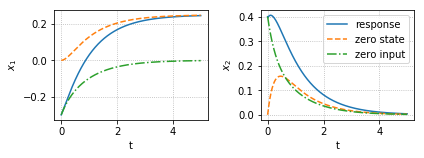

In [2]:
A = [[0, 1],[-4, -5]]
B = [[0], [1]]
C = np.eye(2)
D = np.zeros([2, 1])
P = ss(A, B, C, D)

Td = np.arange(0, 5, 0.01)
Ud = 1*(Td>0) #ステップ入力
X0 = [-0.3, 0.4]

xst, t = step(P, Td) #ゼロ状態応答（ステップ入力）
xin, _ = initial(P, Td, X0) #ゼロ入力応答
x, _, _ = lsim(P, Ud, Td, X0) 

fig, ax = plt.subplots(1, 2, figsize=(6, 2.3)) 
for i in [0, 1]:
    ax[i].plot(t, x[:,i], label='response')
    ax[i].plot(t, xst[:,i], ls='--', label='zero state')
    ax[i].plot(t, xin[:,i], ls='-.', label='zero input')
    ax[i].grid(ls=':')

ax[0].set_xlabel('t')
ax[0].set_ylabel('$x_1$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$x_2$')
ax[1].legend()

fig.tight_layout()

ゼロ状態応答とゼロ入力応答を足すと，完全応答になる

### 可制御性，可観測性

In [3]:
A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [1, 0]
D = [0]
P = ss(A, B, C, D)
print(P)

A = [[ 0.  1.]
 [-4.  5.]]

B = [[0.]
 [1.]]

C = [[1. 0.]]

D = [[0.]]



In [4]:
Uc = ctrb(P.A, P.B)
print('Uc=\n',Uc)
print('det(Uc)=', np.linalg.det(Uc))
print('rank(Uc)=', np.linalg.matrix_rank(Uc))

Uc=
 [[0. 1.]
 [1. 5.]]
det(Uc)= -1.0
rank(Uc)= 2


Ucがフルランク（正則）であるので，(A,B)は可制御

In [5]:
Uo = obsv(P.A, P.C)
print('Uo=\n', Uo)
print('det(Uo)=', np.linalg.det(Uo))
print('rank(Uo)=', np.linalg.matrix_rank(Uo))

Uo=
 [[1. 0.]
 [0. 1.]]
det(Uo)= 1.0
rank(Uo)= 2


Uoがフルランク（正則）であるので，(A,C)は可観測

### 状態フィードバック

極配置による設計

In [6]:
A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = np.eye(2)
D = np.zeros((2,1))
P = ss(A, B, C, D)
print(P.pole())

[1. 4.]


In [7]:
Pole = [-1, -1]
F = -acker(P.A, P.B, Pole)
print('F=',F)
print(np.linalg.eigvals(P.A+P.B*F))

F= [[ 3. -7.]]
[-1. -1.]


極配置ができている

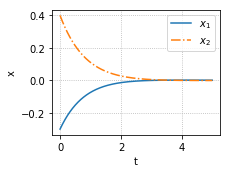

In [8]:
Acl = P.A + P.B*F
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 5, 0.01)
X0 = [-0.3, 0.4]
x, t = initial(Pfb, Td, X0) #ゼロ入力応答

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], label = '$x_1$')
ax.plot(t, x[:,1], ls = '-.', label = '$x_2$')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend()
ax.grid(ls=':')

最適レギュレータ

In [9]:
Q = [ [100, 0], [0, 1]]
R = 1

F, _, _ = lqr(P.A, P.B, Q, R)
F = -F

print('--- フィードバックゲイン ---')
print(F)
print('--- 閉ループ極 ---')
print(np.linalg.eigvals(P.A+P.B*F))

--- フィードバックゲイン ---
[[ -6.77032961 -11.28813639]]
--- 閉ループ極 ---
[-3.14406819+0.94083198j -3.14406819-0.94083198j]


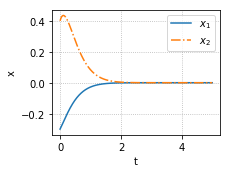

In [10]:
Acl = P.A + P.B*F
Pfb = ss(Acl, P.B, P.C, P.D)

tdata = np.arange(0, 5, 0.01)
xini, tini = initial(Pfb, tdata, [-0.3, 0.4]) #ゼロ入力応答

fig, ax = plt.subplots(figsize=(3, 2.3))

ax.plot(tini, xini[:,0], label = '$x_1$')
ax.plot(tini, xini[:,1], ls = '-.', label = '$x_2$')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend()
ax.grid(ls=':')

### 積分サーボ系

積分サーボ系を構築することで，一定値の目標値に出力を追従させることができます
また，一定値の外乱やモデル化誤差の影響を消すことができます

In [11]:
A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [1, 0]
D = [0]
P = ss(A, B, C, D)

拡大系を構築し，フィードバックゲイン（状態FBと積分器のゲイン）を設計する

In [12]:
Abar = np.r_[ np.c_[P.A, np.zeros((2,1))], -np.c_[ P.C, 0 ] ]
Bbar = np.c_[ P.B.T, 0 ].T
Cbar = np.c_[ P.C, 0 ]

In [13]:
Pole = [-1, -1, -5]
F = -acker(Abar, Bbar, Pole)
F

matrix([[ -7., -12.,   5.]])

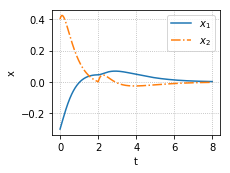

In [14]:
Acl = Abar + Bbar*F
Pfb = ss(Acl, Bbar, np.eye(3), np.zeros((3,1)))

Td = np.arange(0, 8, 0.01)
Ud = 0.5 * (Td>2) # ステップ状の外乱
x, t, _ = lsim(Pfb, Ud, Td, [-0.3, 0.4, 0])
 
fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, x[:,0], label = '$x_1$')
ax.plot(t, x[:,1], ls = '-.',label = '$x_2$')
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.legend()
ax.grid(ls=':')

２秒後に一定値の外乱が加わるが，その影響を受けず最終的に０に収束している

### オブザーバ

In [15]:
A = [[0, 1], [-4, 5]]
B = [[0], [1]]
C = [1, 0]
D = [0]
P = ss(A, B, C, D)

# レギュレータ極
regulator_poles = [-5+5j, -5-5j]
# 極配置
F = -acker(P.A, P.B, regulator_poles)
print(F)

[[-46. -15.]]


オブザーバゲインの設計はackerを用いる．Aの転置とCの転置を引数とすると，Lの転置がもとまる（双対性）

In [16]:
# オブザーバ極
observer_poles=[-15+5j,-15-5j]

# オブザーバゲインの設計（状態フィードバックの双対） 
L = -acker(P.A.T, P.C.T, observer_poles).T
print(L)

[[ -35.]
 [-421.]]


In [17]:
Gsf = ss(P.A + P.B*F, P.B, np.eye(2), [[0],[0]])
Obs = ss(P.A + L*P.C, np.c_[P.B, -L], np.eye(2), np.zeros((2,2)) )

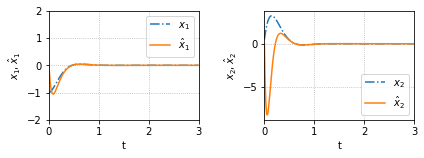

In [18]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

T = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
x, t = initial(Gsf, T, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$')
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$')

# 入力 u = Fx
u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
# 出力 y = Cx
y = x[:, 0]
# オブザーバで推定した状態の振る舞い
xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$')
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$')

for i in [0, 1]:
    ax[i].set_xlabel('t')
    ax[i].set_xlim([0, 3])
    ax[i].grid(ls=':')
    ax[i].legend()

ax[0].set_ylim([-2, 2])
ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')

fig.tight_layout()

### 外乱オブザーバ
出力に一定値の外乱が加わると，オブザーバの推定値に誤差が生じる．そこで，外乱を含めて推定するようにする

In [19]:
# オブザーバ極
observer_poles=[-15+5j,-15-5j, -3] 

# オブザーバゲインの設計（状態フィードバックの双対）
E = [[0], [0]]
Abar = np.r_[ np.c_[P.A, E], np.zeros((1,3))] 
Bbar = np.c_[ P.B.T, np.zeros((1,1)) ].T
Cbar = np.c_[ P.C, 1 ]

Lbar = -acker(Abar.T, Cbar.T, observer_poles).T
print(Lbar)

Fbar = np.c_[ F, 0 ]

Aob = Abar + Lbar*Cbar
Bob = np.c_[Bbar, -Lbar]
Obs = ss(Aob, Bob, np.eye(3), [[0,0],[0,0],[0,0]] )

[[ 149.5]
 [-526. ]
 [-187.5]]


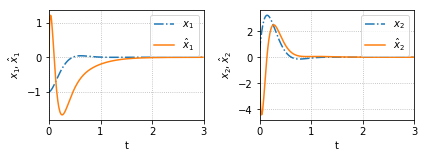

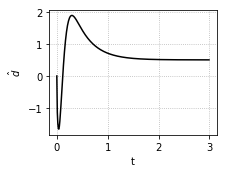

In [20]:
fig, ax = plt.subplots(1,2, figsize=(6, 2.3))

Td = np.arange(0, 3, 0.01)
X0 = [-1, 0.5]
d = 0.5*(T>0)
x, t = initial(Gsf, Td, X0)
ax[0].plot(t, x[:, 0], ls='-.', label='${x}_1$')
ax[1].plot(t, x[:, 1], ls='-.', label='${x}_2$')


# 入力 u = Fx
u = [ [F[0,0]*x[i,0]+F[0,1]*x[i,1]] for i in range(len(x))]
# 出力 y = Cx+d
y = x[:, 0]+d
xhat, t, x0 = lsim(Obs, np.c_[u, y], T, [0, 0, 0])
#xhat, t, x0 = lsim(Obs, x[:, 0]+d, T, [0, 0, 0])
ax[0].plot(t, xhat[:, 0], label='$\hat{x}_1$')
ax[1].plot(t, xhat[:, 1], label='$\hat{x}_2$')

for i in [0, 1]:
    ax[i].grid(ls=':')
    ax[i].set_xlim([0, 3])
    ax[i].set_xlabel('t')
    ax[i].legend()

ax[0].set_ylabel('$x_1, \hat{x}_1$')
ax[1].set_ylabel('$x_2, \hat{x}_2$')

fig.tight_layout()

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t, xhat[:, 2], label='$\hat{x}_2$', color='k')
ax.set_xlabel('t')
ax.set_ylabel('$\hat{d}$')
ax.grid(ls=':')

出力に一定値の外乱が加わっても，推定できる．また，外乱（d=0.5）も推定することができている